In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [2]:
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download darshan1504/covid19-detection-xray-dataset

 96% 179M/186M [00:02<00:00, 116MB/s] 
100% 186M/186M [00:02<00:00, 92.8MB/s]


In [4]:
!unzip -q /content/covid19-detection-xray-dataset.zip

In [5]:
# Commented out IPython magic to ensure Python compatibility.
import os
import glob
import h5py
import shutil
import imgaug as aug #augment data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt #plot stuff/show images
import matplotlib.image as mimg
import imgaug.augmenters as iaa #augment data(data is imbalanced)
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path #get data
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
#from keras.applications import ResNet50, preprocess_input #transfer learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
#convolutional nueral networks
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.merge import Concatenate
from tensorflow.keras.layers import concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()

In [6]:
#get data
data_dir1 = Path('../content')
data_dir2 = Path('../content/TrainData')
data_dir3 = Path('../content/ValData')
# data_dir4 = Path('../content/pneumonia-virus-vs-covid19/Pneumonia_and_COVID19')

In [7]:
data = []
normal_data = []
bacterial_data = []
viral_data = []

In [8]:
loop_dir2 = ['NonAugmentedTrain', 'ValData']
for i in loop_dir2:
    normal_dir2 = data_dir1 / i / 'Normal'
    bacterial_dir2 = data_dir1 / i / 'BacterialPneumonia'
    viral_dir2 = data_dir1 / i / 'ViralPneumonia'
    normal_cases2 = normal_dir2.glob('*.jpeg')
    bacterial_cases2 = bacterial_dir2.glob('*.jpeg')
    viral_cases2 = viral_dir2.glob('*.jpeg')
    for img in normal_cases2:
        normal_data.append((img,0))
    for img in bacterial_cases2:
        bacterial_data.append((img,1))
    for img in viral_cases2:
        viral_data.append((img,2))

In [9]:
print('number of normal cases: ' + str(len(normal_data)))
print('number of bacterial cases: ' + str(len(bacterial_data)))
print('number of viral cases: ' + str(len(viral_data)))

number of normal cases: 1330
number of bacterial cases: 974
number of viral cases: 617


In [11]:
str(len(normal_data))

data = normal_data + bacterial_data + viral_data
del normal_data, bacterial_data, viral_data, data_dir1, data_dir2, data_dir3

In [12]:
data = pd.DataFrame(data, columns=['image', 'label'],index=None)
#shuffle
data = data.sample(frac=1.).reset_index(drop=True)
#print
data.head()

,image,label
0,../content/ValData/Normal/305.jpeg,0
1,../content/ValData/ViralPneumonia/81.jpeg,2
2,../content/ValData/Normal/374.jpeg,0
3,../content/ValData/Normal/365.jpeg,0
4,../content/ValData/ViralPneumonia/175.jpeg,2


In [13]:
# Get the counts for each class
cases_count = data['label'].value_counts()
print(cases_count)

0    1780
1     974
2     617
Name: label, dtype: int64


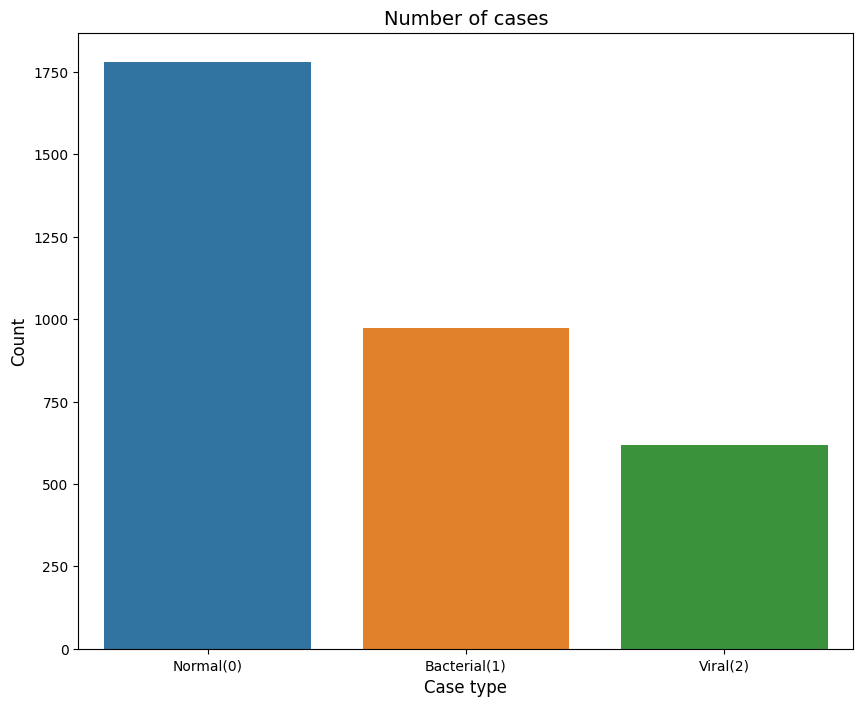

In [14]:
# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bacterial(1)', 'Viral(2)'])
plt.show()
del cases_count

In [15]:
#show sample
viral_samples = (data[data['label']==2]['image'].iloc[:5]).tolist()
bacterial_samples = (data[data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (data[data['label']==0]['image'].iloc[:5]).tolist()

In [16]:
# Concat the data in a single list and del the above 3 lists
samples = viral_samples + bacterial_samples + normal_samples
del viral_samples, normal_samples, bacterial_samples

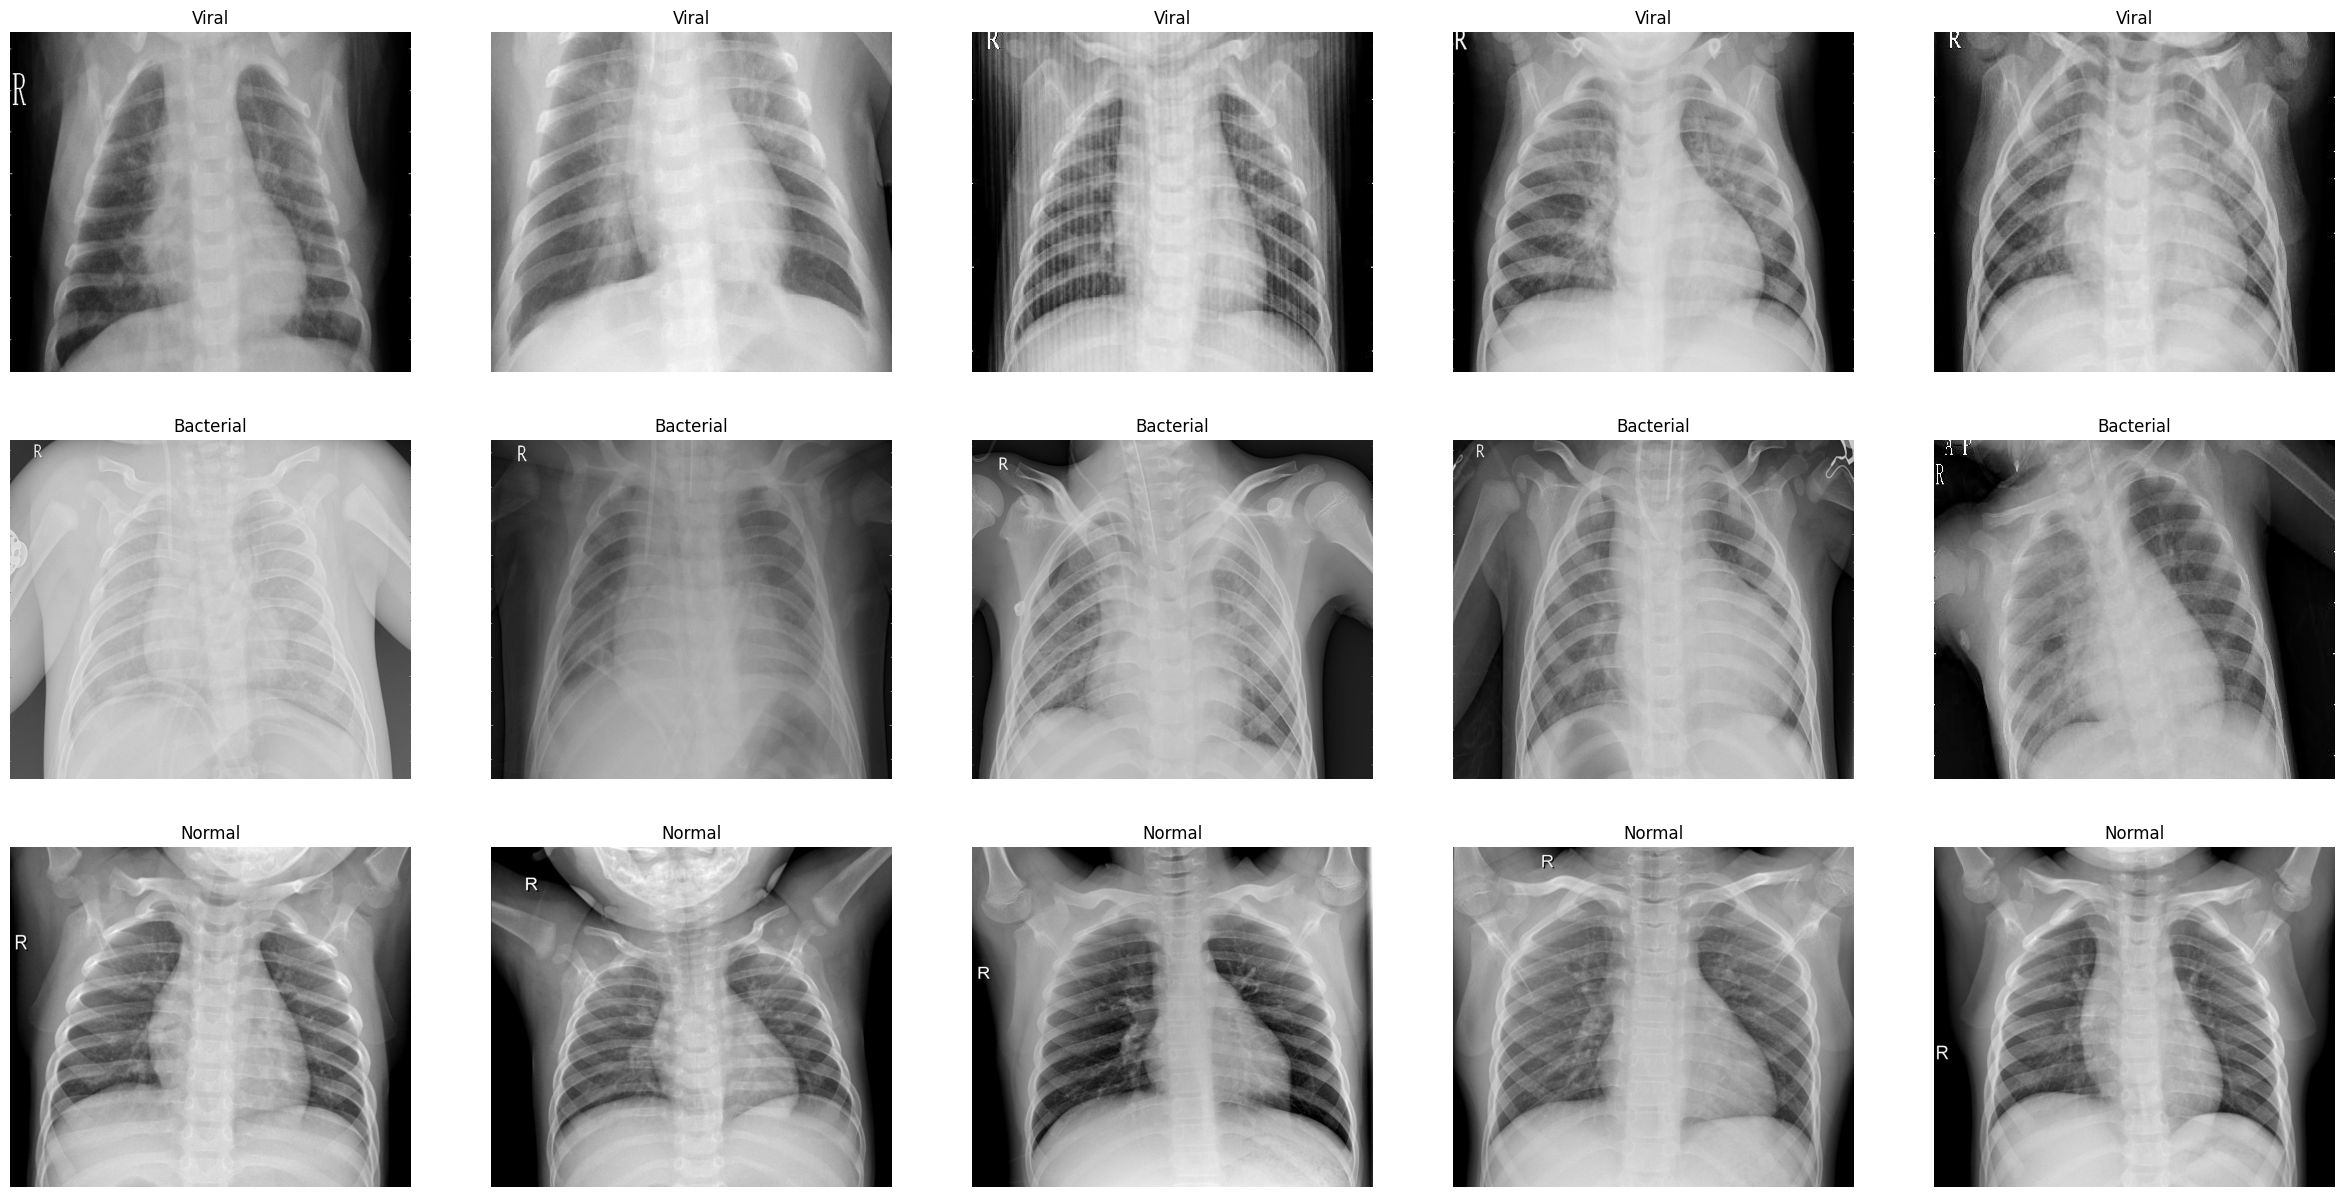

In [17]:
# Plot the data
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Viral")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Bacterial")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [18]:
data = data.iloc[: int(data.shape[0]/2)]
print(data.shape)

(1685, 2)


In [19]:
image_data = []
label_data = []
for index, d in data.iterrows():
    img = d['image']
    l = d['label']
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(l, num_classes=3)
    image_data.append(img)
    label_data.append(label)
image_data = np.array(image_data)
label_data = np.array(label_data)
del data

In [20]:
image_train, image_validate, image_test = np.split(image_data, [int(.7*len(image_data)), int(.85*len(image_data))])
label_train, label_validate, label_test = np.split(label_data, [int(.7*len(label_data)), int(.85*len(label_data))])
print('number of training images and labels: ' + str(len(image_train)) + ' and ' + str(len(label_train)))
print('number of validation images and labels: ' + str(len(image_validate)) + ' and ' + str(len(label_validate)))
print('number of test images and labels: ' + str(len(image_test)) + ' and ' + str(len(label_test)))
del image_data, label_data

number of training images and labels: 1179 and 1179
number of validation images and labels: 253 and 253
number of test images and labels: 253 and 253


In [21]:
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

94765736/94765736 [==============================] - 2s 0us/step


In [22]:
len(base_model.layers)

175

In [23]:
fine_tune = 20
for layer in base_model.layers[:fine_tune]:
    layer.trainable = False

In [24]:
early_stop=EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(3, activation = 'softmax')
])

In [27]:
import tensorflow as tf
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = 'accuracy'
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 23,733,955
Non-trainable params: 154,816
_________________________________________________________________


In [29]:
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [30]:
batch_size = 16
with tf.device('/gpu:0'):
    model.fit(image_train, label_train, \
                    validation_data=(image_validate, label_validate), \
                    epochs=20, callbacks=[early_stopping_monitor], batch_size=batch_size, verbose = 0)

In [31]:
test_loss, test_score = model.evaluate(image_test, label_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

16/16 [==============================] - 1s 54ms/step - loss: 1.2954 - accuracy: 0.5455
Loss on test set:  1.295441746711731
Accuracy on test set:  0.5454545617103577


In [32]:
# Get predictions
preds = model.predict(image_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

16/16 [==============================] - 2s 50ms/step


In [33]:
# Original labels
orig_test_labels = np.argmax(label_test, axis=-1)

In [34]:
print(orig_test_labels.shape)
print(preds.shape)

(253,)
(253,)


<Figure size 640x480 with 0 Axes>

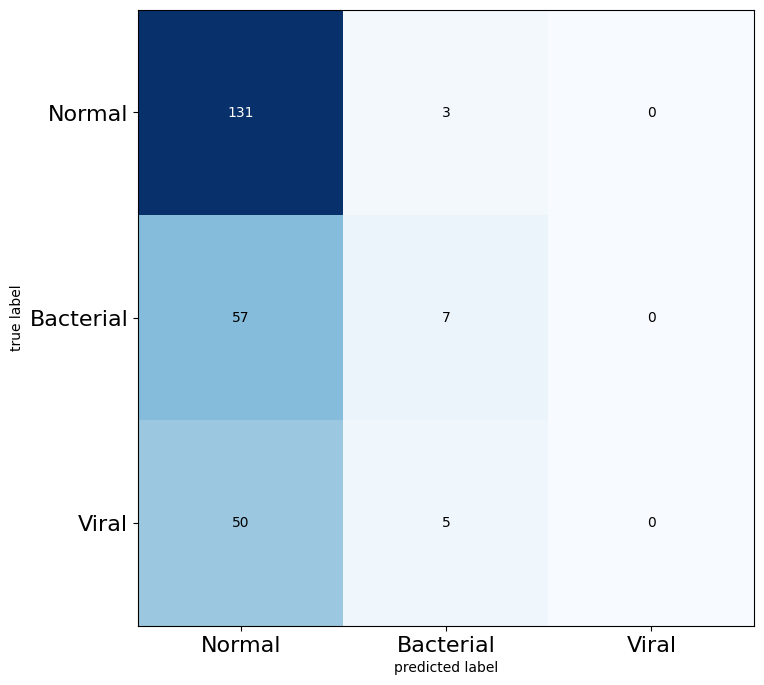

In [35]:

# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.show()

In [36]:
nn, nb, nv, bn, bb, bv, vn, vb, vv = cm.ravel()
normal_precision = nn/(nn+bn+vn)
normal_recall = nn/(nn+nb+nv)
bacterial_precision = bb/(nb+bb+vb)
bacterial_recall = nn/(bn+bb+bv)
viral_precision = nn/(nv+bv+vv)
viral_recall = nn/(vn+vb+vv)
print("Recall of the model when dealing with heathly lungs is {:.2f}".format(normal_recall))
print("Precision of the model when dealing with heathly lungs is {:.2f}".format(normal_precision))
print("Recall of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_recall))
print("Precision of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_precision))
print("Recall of the model when dealing with viral pneumonia is {:.2f}".format(viral_recall))
print("Precision of the model when dealing with viral pneumonia is {:.2f}".format(viral_precision))

Recall of the model when dealing with heathly lungs is 0.98
Precision of the model when dealing with heathly lungs is 0.55
Recall of the model when dealing with bacterial pneumonia is 2.05
Precision of the model when dealing with bacterial pneumonia is 0.47
Recall of the model when dealing with viral pneumonia is 2.38
Precision of the model when dealing with viral pneumonia is inf


<ipython-input-36-afc7a6103ded>:6: RuntimeWarning: divide by zero encountered in long_scalars
  viral_precision = nn/(nv+bv+vv)
